### Predicting gender from student data
This notebook uses Student Alcohol Consumption dataset from Kaggle. It contains demographic,  social and academic information relating to students in a maths course at two secondary schools in Portugal. 
Objective is to determine if factors given in the dataset contribute to predicting the gender of a student. Both  a Decision Tree Classifier model and a Logistic Regression model are set up, for comparison. GridSearchCV is also used to get the best fitted models for both.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

%matplotlib inline

import graphviz
import pydotplus
import io
from scipy import misc

/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv("data/student-alcohol-maths.csv")
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [3]:
df.shape

(395, 33)

In [4]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


### Total number of student records.

In [5]:
#total students 
num_total = len(df)
print("Total number of student records: ", num_total)

Total number of student records:  395


### % of students from each school.

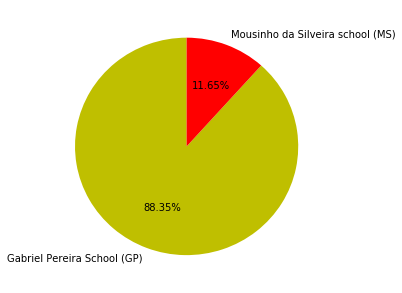

In [6]:
#total students 
num_total = len(df)

#Number of GP students
num_gp = df["school"].value_counts()["GP"]

#Number of MS students
num_ms = df["school"].value_counts()["MS"]

#define pie chart values
school_figs = [num_gp, num_ms]
school_name = ["Gabriel Pereira School (GP)", "Mousinho da Silveira school (MS)"]

#set pie chart colors
colors = ["y", "r"]
plt.pie(school_figs, labels=school_name, colors=colors, startangle=90, autopct="%.2f%%")

#change the size of the pie chart.
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.show()

### % of boys & girls in the study. 

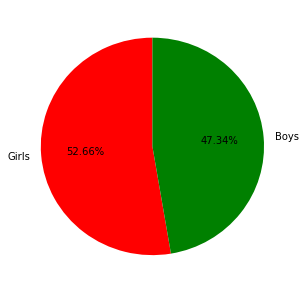

In [7]:
num_total = len(df)

#Number of girls in the study
girls = df["sex"].value_counts()["F"]

#Number of boys in the study
boys = df["sex"].value_counts()["M"]

#define pie chart values
numbers = [girls, boys]
name = ["Girls", "Boys"]

#set pie chart colors
colors = ["r", "g"]
plt.pie(numbers, labels=name, colors=colors, startangle=90, autopct="%.2f%%")

#change the size of the pie chart.
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.show()

### This plots a summary of all the study features (%).

Text(0.5,699,'Grade (G3)')

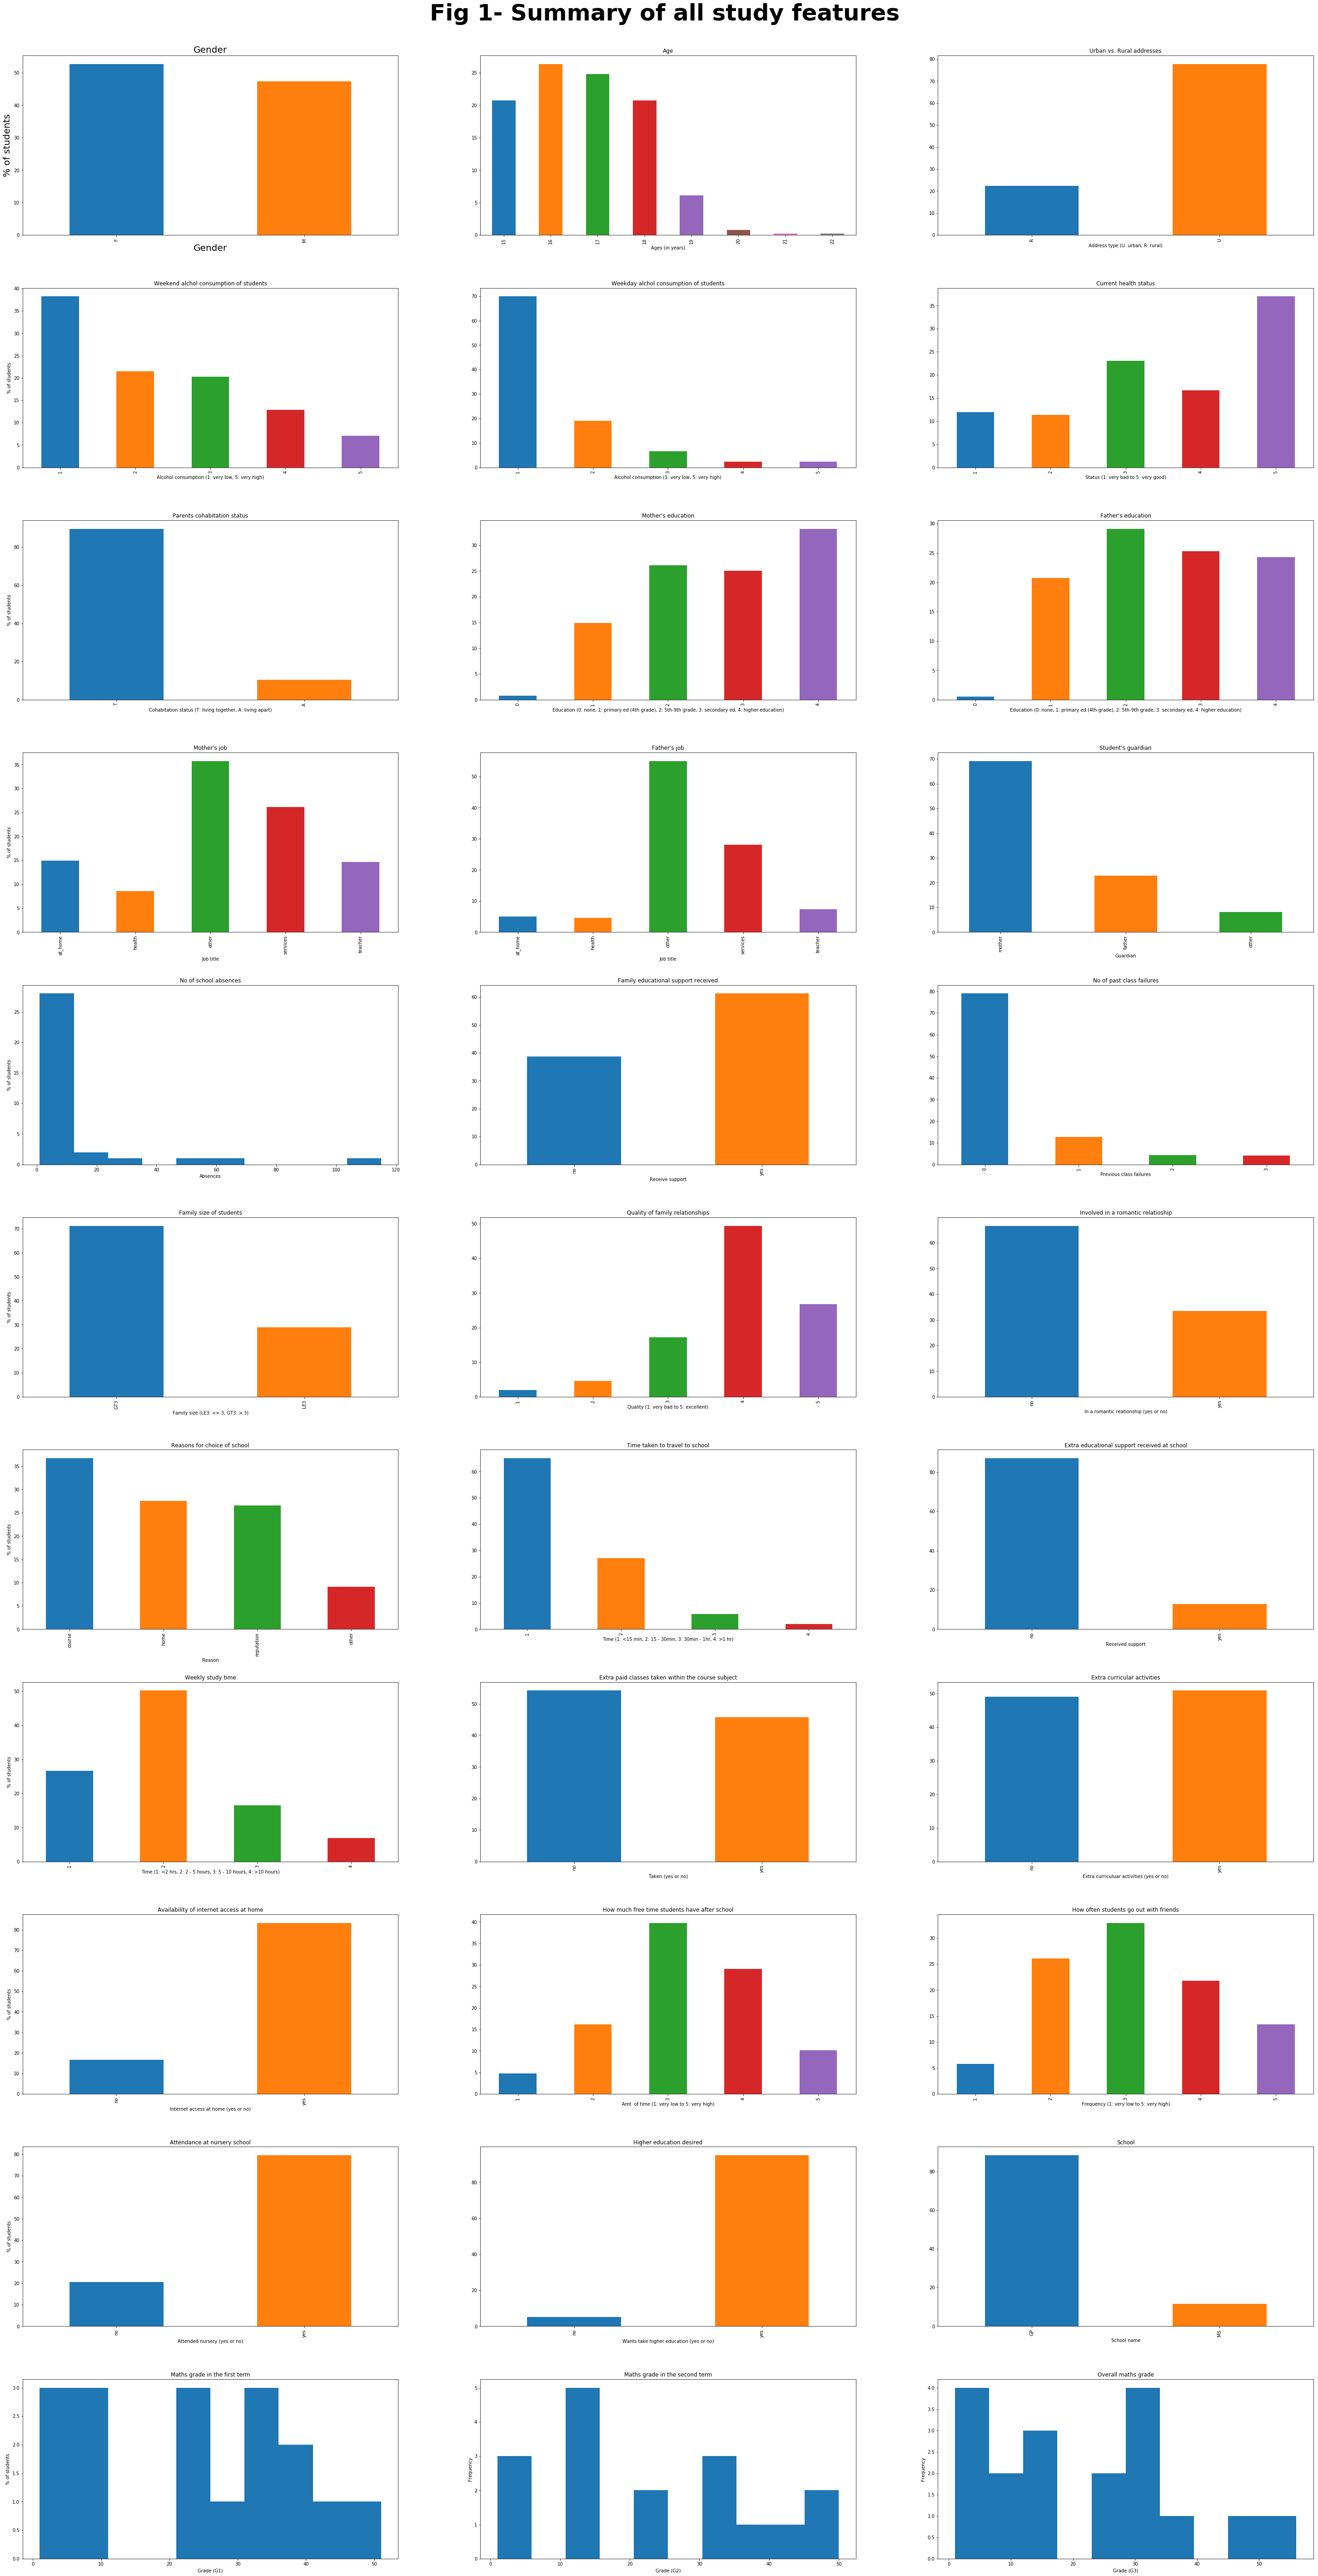

In [44]:
#Setting up a figure to accomodate the 30 features given in the dataset, in 30 subplots. 
fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(40, 80))
fig.tight_layout(pad=0.4, w_pad=15, h_pad=10)
fig.suptitle("Fig 1- Summary of all study features", fontweight="bold", size=50)
fig.subplots_adjust(top=0.96)

#sex
gender = (df["sex"].value_counts() / df["sex"].count()) * 100
gender.plot(kind="bar", ax=axes[0,0])
axes[0,0].set_title("Gender", fontsize=20)
axes[0,0].set_xlabel("Gender", fontsize=20)
axes[0,0].set_ylabel("% of students", fontsize=20)
                     
#age
age = (df["age"].value_counts() / df["age"].count()) * 100
age.sort_index().plot(kind="bar", ax=axes[0,1])
axes[0,1].set_title("Age")
axes[0,1].set_xlabel("Ages (in years)")

#address
address = (df["address"].value_counts() / df["address"].count()) * 100
address.sort_index().plot(kind="bar", ax=axes[0,2])
axes[0,2].set_title("Urban vs. Rural addresses")
axes[0,2].set_xlabel("Address type (U: urban, R: rural)")


#weekend alcohol consumption
walc = (df["Walc"].value_counts() / df["Walc"].count()) * 100
walc.sort_index().plot(kind="bar", ax=axes[1,0])
axes[1,0].set_title("Weekend alchol consumption of students")
axes[1,0].set_xlabel("Alcohol consumption (1: very low, 5: very high)")
axes[1,0].set_ylabel("% of students")

#daily alcohol consumption
dalc = (df["Dalc"].value_counts() / df["Dalc"].count()) * 100
dalc.sort_index().plot(kind="bar", ax=axes[1,1])
axes[1,1].set_title("Weekday alchol consumption of students")
axes[1,1].set_xlabel("Alcohol consumption (1: very low, 5: very high)")

#current health status
health = (df["health"].value_counts() / df["health"].count()) * 100
health.sort_index().plot(kind="bar", ax=axes[1,2])
axes[1,2].set_title("Current health status")
axes[1,2].set_xlabel("Status (1: very bad to 5: very good)")


#parents cohabitation status
pstatus = (df["Pstatus"].value_counts() / df["Pstatus"].count()) * 100
pstatus.plot(kind="bar", ax=axes[2,0])
axes[2,0].set_title("Parents cohabitation status")
axes[2,0].set_xlabel("Cohabitation status (T: living together, A: living apart)")
axes[2,0].set_ylabel("% of students")

#mother's education
medu = (df["Medu"].value_counts() / df["Medu"].count()) * 100
medu.sort_index().plot(kind="bar", ax=axes[2,1])
axes[2,1].set_title("Mother's education")
axes[2,1].set_xlabel("Education (0: none, 1: primary ed (4th grade), 2: 5th-9th grade, 3: secondary ed, 4: higher education)")

#father's education
fedu = (df["Fedu"].value_counts() / df["Fedu"].count()) * 100
fedu.sort_index().plot(kind="bar", ax=axes[2,2])
axes[2,2].set_title("Father's education")
axes[2,2].set_xlabel("Education (0: none, 1: primary ed (4th grade), 2: 5th-9th grade, 3: secondary ed, 4: higher education)")


#mother's job
mjob = (df["Mjob"].value_counts() / df["Mjob"].count()) * 100
mjob.sort_index().plot(kind="bar", ax=axes[3,0])
axes[3,0].set_title("Mother's job")
axes[3,0].set_xlabel("Job title")
axes[3,0].set_ylabel("% of students")

#father's job
fjob = (df["Fjob"].value_counts() / df["Fjob"].count()) * 100
fjob.sort_index().plot(kind="bar", ax=axes[3,1])
axes[3,1].set_title("Father's job")
axes[3,1].set_xlabel("Job title")

#student's guardian
guardian = (df["guardian"].value_counts() / df["guardian"].count()) * 100
guardian.plot(kind="bar", ax=axes[3,2])
axes[3,2].set_title("Student's guardian")
axes[3,2].set_xlabel("Guardian")


#number of school absences
absences = df["absences"].value_counts()
absences.plot(kind="hist", bins=10, ax=axes[4,0])
axes[4,0].set_title("No of school absences")
axes[4,0].set_xlabel("Absences")
axes[4,0].set_ylabel("% of students")

#family education support
famsup = (df["famsup"].value_counts() / df["famsup"].count()) * 100
famsup.sort_index().plot(kind="bar", ax=axes[4,1])
axes[4,1].set_title("Family educational support received")
axes[4,1].set_xlabel("Receive support")

#no of past class failures
failures = (df["failures"].value_counts() / df["failures"].count()) * 100
failures.sort_index().plot(kind="bar", ax=axes[4,2])
axes[4,2].set_title("No of past class failures")
axes[4,2].set_xlabel("Previous class failures")


#family size
famsize = (df["famsize"].value_counts() / df["famsize"].count()) * 100
famsize.plot(kind="bar", ax=axes[5,0])
axes[5,0].set_title("Family size of students")
axes[5,0].set_xlabel("Family size (LE3: <= 3, GT3: > 3)")
axes[5,0].set_ylabel("% of students")

#quality of family relationships
famrel = (df["famrel"].value_counts() / df["famrel"].count()) * 100
famrel.sort_index().plot(kind="bar", ax=axes[5,1])
axes[5,1].set_title("Quality of family relationships")
axes[5,1].set_xlabel("Quality (1: very bad to 5: excellent)")

#with a romantic relationship
romantic = (df["romantic"].value_counts() / df["romantic"].count()) * 100
romantic.sort_index().plot(kind="bar", ax=axes[5,2])
axes[5,2].set_title("Involved in a romantic relatioship")
axes[5,2].set_xlabel("In a romantic reationship (yes or no)")


#reason to choose the school
reason = (df["reason"].value_counts() / df["reason"].count()) * 100
reason.plot(kind="bar", ax=axes[6,0])
axes[6,0].set_title("Reasons for choice of school")
axes[6,0].set_xlabel("Reason")
axes[6,0].set_ylabel("% of students")

#home to school travel time
traveltime = (df["traveltime"].value_counts() / df["traveltime"].count()) * 100
traveltime.sort_index().plot(kind="bar", ax=axes[6,1])
axes[6,1].set_title("Time taken to travel to school")
axes[6,1].set_xlabel("Time (1: <15 min, 2: 15 - 30min, 3: 30min - 1hr, 4: >1 hr)")

#extra educational support
schoolsup = (df["schoolsup"].value_counts() / df["schoolsup"].count()) * 100
schoolsup.sort_index().plot(kind="bar", ax=axes[6,2])
axes[6,2].set_title("Extra educational support received at school")
axes[6,2].set_xlabel("Received support")


#weekly study time
studytime = (df["studytime"].value_counts() / df["studytime"].count()) * 100
studytime.sort_index().plot(kind="bar", ax=axes[7,0])
axes[7,0].set_title("Weekly study time")
axes[7,0].set_xlabel("Time (1: <2 hrs, 2: 2 - 5 hours, 3: 5 - 10 hours, 4: >10 hours)")
axes[7,0].set_ylabel("% of students")

#extra paid classes in Maths
paid = (df["paid"].value_counts() / df["paid"].count()) * 100
paid.sort_index().plot(kind="bar", ax=axes[7,1])
axes[7,1].set_title("Extra paid classes taken within the course subject")
axes[7,1].set_xlabel("Taken (yes or no)")

#extra curricular activities
activities = (df["activities"].value_counts() / df["activities"].count()) * 100
activities.sort_index().plot(kind="bar", ax=axes[7,2])
axes[7,2].set_title("Extra curricular activities")
axes[7,2].set_xlabel("Extra curriculuar activities (yes or no)")


#internet access at home
internet = (df["internet"].value_counts() / df["internet"].count()) * 100
internet.sort_index().plot(kind="bar", ax=axes[8,0])
axes[8,0].set_title("Availability of internet access at home")
axes[8,0].set_xlabel("Internet access at home (yes or no)")
axes[8,0].set_ylabel("% of students")

#free time after school
freetime = (df["freetime"].value_counts() / df["freetime"].count()) * 100
freetime.sort_index().plot(kind="bar", ax=axes[8,1])
axes[8,1].set_title("How much free time students have after school")
axes[8,1].set_xlabel("Amt. of time (1: very low to 5: very high)")

#going out with friends
goout = (df["goout"].value_counts() / df["goout"].count()) * 100
goout.sort_index().plot(kind="bar", ax=axes[8,2])
axes[8,2].set_title("How often students go out with friends")
axes[8,2].set_xlabel("Frequency (1: very low to 5: very high)")


#attended nursery school
nursery = (df["nursery"].value_counts() / df["nursery"].count()) * 100
nursery.sort_index().plot(kind="bar", ax=axes[9,0])
axes[9,0].set_title("Attendance at nursery school")
axes[9,0].set_xlabel("Attended nursery (yes or no)")
axes[9,0].set_ylabel("% of students")

#wants to take higher education
higher = (df["higher"].value_counts() / df["higher"].count()) * 100
higher.sort_index().plot(kind="bar", ax=axes[9,1])
axes[9,1].set_title("Higher education desired")
axes[9,1].set_xlabel("Wants take higher education (yes or no)")

#student's school
school = (df["school"].value_counts() / df["school"].count()) * 100
school.sort_index().plot(kind="bar", ax=axes[9,2])
axes[9,2].set_title("School")
axes[9,2].set_xlabel("School name")


#first period grade
g1 = df["G1"].value_counts()
g1.plot(kind="hist", bins=10, ax=axes[10,0])
axes[10,0].set_title("Maths grade in the first term")
axes[10,0].set_xlabel("Grade (G1)")
axes[10,0].set_ylabel("% of students")

#second period grade
g2 = df["G2"].value_counts()
g2.plot(kind="hist", bins=10, ax=axes[10, 1])
axes[10,1].set_title("Maths grade in the second term")
axes[10,1].set_xlabel("Grade (G2)")

#final grade
g3 = df["G3"].value_counts()
g3.plot(kind="hist", bins=10, ax=axes[10, 2])
axes[10,2].set_title("Overall maths grade")
axes[10,2].set_xlabel("Grade (G3)") 

### Setting up the Decision Tree Classifier model. Aim is to predict the gender of a student based on the features given below

In [9]:
#define features and target variable for decision tree model.
#convert categorical variables into dummy variables.
X = pd.get_dummies(df.loc[:, df.columns != "sex"])
y = df.loc[:, "sex"]

In [10]:
#separate dataset into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)  

In [11]:
#instantiate decision tree classifier object with max depth.
clf = DecisionTreeClassifier(max_depth=3)

In [12]:
#fitting classifier to the training set.
dt = clf.fit(X_train, y_train)

In [13]:
#to predict the test set results.
y_pred = clf.predict(X_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


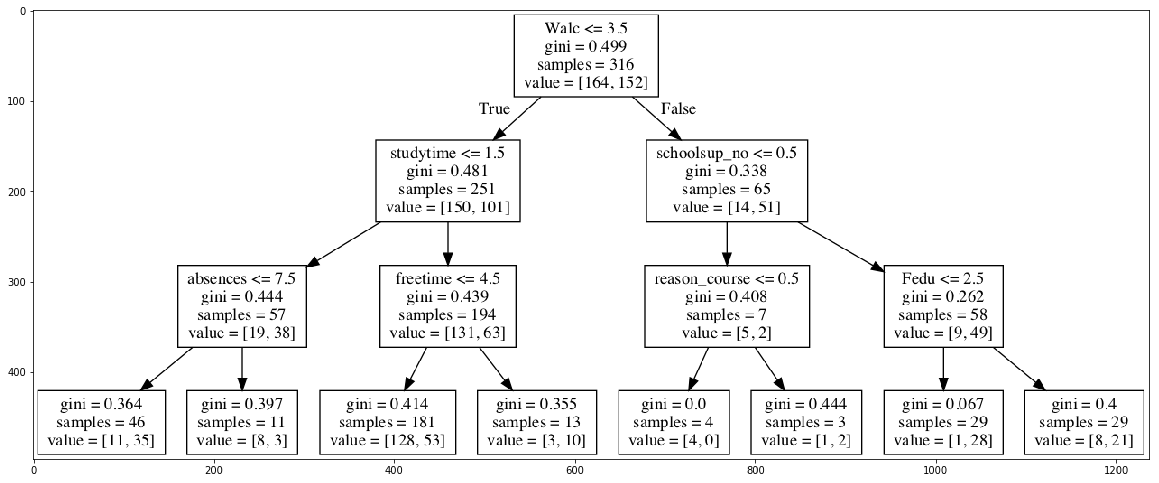

In [14]:
#function to produce decision tree image
def show_tree(tree, X, path):
    f=io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=X.columns)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img=misc.imread(path)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.imshow(img)
show_tree(dt, X, "student_data_tree.png")

### Accuracy of the Decision Tree Classifier model in predicting the gender of a student

In [15]:
#decision tree model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score using Decision Tree: %.2f%%" % (accuracy * 100.0))

Accuracy score using Decision Tree: 70.89%


In [16]:
#making the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix for Decision Tree Classifier model:")
print(cm)

Confusion matrix for Decision Tree Classifier model:
[[38  6]
 [17 18]]


In [17]:
#splitting the confusion matrix into 4 parts
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 18
True Negatives: 38
False Positives: 6
False Negatives: 17


In [18]:
sensitivity = tp / float(tp + fn)
print("Sensitivity: %.2f%%" % (sensitivity * 100))

Sensitivity: 51.43%


In [19]:
specificity= tn / float(tn + fp)
print("Specificity: %.2f%%" % (specificity * 100))

Specificity: 86.36%


In [20]:
FP = fp / float(tn + fp)
print("False Positive rate: %.2f%%" % (FP * 100))

False Positive rate: 13.64%


In [21]:
prec = tp / float(fp + tp)
print("Precision rate: %.2f%%" % (prec * 100))

Precision rate: 75.00%


### Make predictions with the decision tree classifier model

In [22]:
#make predictions using 2 student records.
#obs1 is a record from the student dataset (gender="M").
#obs2 is a new record that has been made up- not part of the student dataset.

obs1 = [[1, 0, 15, 1, 0, 1, 0, 0, 1, 3, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 4, 2, 2, 1, 1, 1, 0, 16, 18, 19]]
obs2 = [[0, 0 , 0, 1, 20, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 3, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 4, 3, 2, 3, 12, 10, 15]]

In [23]:
#Use observations to predict gender of student using decision tree model.
print("Prediction for observation 1 using decision tree: {}".format(dt.predict(obs1)))
print("Prediction for observation 2 using decision tree: {}".format(dt.predict(obs2)))

Prediction for observation 1 using decision tree: ['M']
Prediction for observation 2 using decision tree: ['F']


In [24]:
#view predicted class probabilities 
print("Predicted probabilities for observation 1: {}".format(dt.predict_proba(obs1)))
print("Predicted probabilities for observation 2: {}".format(dt.predict_proba(obs2)))

Predicted probabilities for observation 1: [[0.23913043 0.76086957]]
Predicted probabilities for observation 2: [[0.70718232 0.29281768]]


### Getting the best fitted decision tree classifier model using GridSearchCV.

In [25]:
#setting parameters. 
dep = np.arange(1, 9)
param_grid = {"max_depth" : dep}

#instantiate decision tree classifier.
tree = DecisionTreeClassifier()

#instantiate GridSearchCV for decision tree classifier.
tree_cv = GridSearchCV(tree, param_grid=param_grid, cv=5)

#fitting classifier to X and y data values.
tree_cv.fit(X, y)
score = tree_cv.best_score_
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best accuracy score is: %.2f%%" % (score * 100))

Tuned Decision Tree Parameters: {'max_depth': 4}
Best accuracy score is: 72.91%


### Make predictions with the best fitted decision tree classifier model using GridSearchCV.

In [26]:
#Use the observations created above for the decision tree classifier model above.
#predict gender of student.
print("Prediction for observation 1 using best fitted decision tree: {}".format(tree_cv.predict(obs1)))
print("Prediction for observation 2 using best fitted decision tree: {}".format(tree_cv.predict(obs2)))

Prediction for observation 1 using best fitted decision tree: ['M']
Prediction for observation 2 using best fitted decision tree: ['F']


In [27]:
#view predicted class probabilities (male/female)
print("Predicted probabilities for observation 1: {}".format(tree_cv.predict_proba(obs1)))
print("Predicted probabilities for observation 2: {}".format(tree_cv.predict_proba(obs2)))

Predicted probabilities for observation 1: [[0. 1.]]
Predicted probabilities for observation 2: [[0.7638191 0.2361809]]


###  Setting up the Logistic Regression  model.  Aim is to predict the gender of a student based on the features. Compare results of Logistic Regression model to Decision Tree model. 

In [28]:
#define features and target variable for the logistic regression model
features = pd.get_dummies(df.loc[:, df.columns != "sex"])
target = df.loc[:, "sex"]

In [29]:
#separate dataset into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [30]:
#instantiate logistic regression.
logreg = LogisticRegression()

In [31]:
#fit logistic regression model to the training set.
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
#to predict the test set results.
y_pred_class = logreg.predict(X_test)

### Accuracy of the Logistic Regression model in predicting the gender of a student. 

In [33]:
#logistic regression model accuracy
lm_accuracy = metrics.accuracy_score(y_test, y_pred_class)
print("Accuracy score using Logistic Regression: %.2f%%" % (lm_accuracy * 100.0))

Accuracy score using Logistic Regression: 67.09%


In [34]:
#logistic regression confusion matrix
cm_log = metrics.confusion_matrix(y_test, y_pred_class)
print("Confusion matrix for Logistic Regression model:")
print(cm_log)

Confusion matrix for Logistic Regression model:
[[25 13]
 [13 28]]


In [35]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

True Positives: 28
True Negatives: 25
False Positives: 13
False Negatives: 13


In [36]:
sensitivity = TP / float(TP + FN)
print("Sensitivity: %.2f%%" % (sensitivity * 100))

Sensitivity: 68.29%


In [37]:
specificity= TN / float(TN + FP)
print("Specificity: %.2f%%" % (specificity * 100))

Specificity: 65.79%


In [38]:
fp = FP / float(TN + FP)
print("False Positive rate: %.2f%%" % (fp * 100))

False Positive rate: 34.21%


In [39]:
precision = TP / float(FP + TP)
print("Precision rate: %.2f%%" % (precision * 100))

Precision rate: 68.29%


### Make predictions with the logistic regression model

In [40]:
#Use the observation created above for the decision tree classifier model above.
#Use observations to predict gender of student.
print("Prediction for observation 1 using logistic regression model: {}".format(logreg.predict(obs1)))
print("Prediction for observation 2 using logistic regression model: {}".format(logreg.predict(obs2)))

Prediction for observation 1 using logistic regression model: ['F']
Prediction for observation 2 using logistic regression model: ['F']


### Getting the best fitted logistic regression model using GridSearchCV.

In [41]:
#setting parameters
grid = {"C":np.logspace(-3, 3, 7)}

#create a GridSearchCV for logistic regression
logreg_cv = GridSearchCV(logreg, grid, cv=6)

#fitting classifier to X and y data values.
logreg_cv.fit(X_train, y_train)

logreg_score = logreg_cv.best_score_
print("Tuned Logistic Regression Parameners: {}".format(logreg_cv.best_params_))
print("Best accuracy score is: %.2f%%" % (logreg_score * 100))

Tuned Logistic Regression Parameners: {'C': 0.1}
Best accuracy score is: 70.89%


### Make predictions with the best fitted logistic regression model using GridSearchCV

In [42]:
#Use the observation created above for the decision tree classifier model above.
#Use observations to predict gender of student.
print("Prediction for observation 1 using best fitted logistic regression model: {}".format(logreg_cv.predict(obs1)))
print("Prediction for observation 2 using best fitted logistic regression model: {}".format(logreg_cv.predict(obs2)))

Prediction for observation 1 using best fitted logistic regression model: ['M']
Prediction for observation 2 using best fitted logistic regression model: ['F']
